## <center><ins>Trabajo Práctico 2: Criticas de peliculas</ins></center>
#### <center>*XGBoost*</center>
##### <center>75.06 / 95.58 Organización de Datos - FIUBA</center>
##### <center>Ing. Rodríguez - 1°C 2023</center>
---
#### <center>**Grupo 31 - "Datazo":**</center>
<center> Michael Mena - 102685</center>
<center>Pablo Brocca - 104256</center>
<center>Diego Kisinovsky - 106203</center>

---
---

## Carga de datos y librerías

In [1]:
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Metricas
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Clasificadores
from xgboost import XGBClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline

# Optimización de hiperparámetros
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Categorical

# Manejo de modelos
from pickle import dump
from pickle import load


In [2]:
df = pd.read_csv('../input/dataset/train_preprocesado.csv', sep=',', header=0)
df.head()

,review_es,sentimiento,longitud
0,Uno de los otros críticos ha mencionado que de...,1,0.583940
1,Una pequeña pequeña producción.La técnica de f...,1,-0.324820
2,Pensé que esta era una manera maravillosa de p...,1,-0.394205
3,"Básicamente, hay una familia donde un niño peq...",0,-0.585980
4,"El ""amor en el tiempo"" de Petter Mattei es una...",1,0.007653


### Carga stopwords

In [3]:
sw = pd.read_csv('../input/dataset/my-stop-words.csv')['palabra'].to_list() # 390 palabras, 77 nuevas agregadas a mano y 308 de NLTK

print(f'Cantidad de stopwords: {len(sw)}')

Cantidad de stopwords: 390


### Definicón de funciones

In [4]:
#Funcion para evaluar los modelos
def evaluate_model(model, x, y, splits=5, repeats=2, metric='f1'):
    cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=1)
    scores = cross_val_score(model, x, y, scoring=metric, cv=cv, verbose=1, n_jobs=-1, error_score='raise')
    return scores

## Armado y entrenamiento

### Preparación de features:

In [5]:
target = 'sentimiento'

# Se elimina el target del las features
features = df.columns.tolist()
features.remove(target)
features

['review_es', 'longitud']

### Train-Test Split:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df[target], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df[target],
                                                    shuffle=True)

# Verificamos cantidad de datos en cada set
print('# Datos Entrenamiento: {}'.format(len(X_train)))
print('# Datos Prueba: {}'.format(len(X_test)))

# Verificamos como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 40000
# Datos Prueba: 10000
% Positivos Entrenamiento: 50.000
% Positivos Prueba: 50.000


### Entrenamiento de modelo

#### Optimizacion bayesiana

In [7]:
vectorizer = TfidfVectorizer(smooth_idf=True, # Suaviza el IDF al agregar 1 a todos los documentos, como si hubiera un documento más con todas las palabras del vocabulario
                                    norm='l1', # Normalización por filas (cada fila suma 1)
                                    strip_accents='unicode', # Remueve acentos y tildes
#                                     max_features=10000, # Si se quiere usar el vocabulario completo, quitar este parámetro
                                    sublinear_tf=True, # Reemplaza tf por 1 + log(tf), puede ayudar a reducir la importancia de las palabras 
                                    #muy frecuentes que tienden a dominar el cálculo de las ponderaciones
                                    analyzer='word', stop_words=sw, 
                                    ngram_range=(1, 1) )

# (1,1) unigramas, (2,2) bigramas y (3,3) trigramas, (1,3) los tres mencionados anteriormente. A mayor ngram_range, más features (amplia el vocabulario)

In [8]:
# Crear el objeto de preprocesamiento para la columna 'review_es' (olo se aplica tfidfvectorizer a esta columna)
preprocessor = ColumnTransformer([
    ('tfidfvectorizer', vectorizer,
     'review_es')
])

# Crear la pipeline con preprocesamiento y el modelo RandomForest
model = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(
                            n_jobs=-1,
#                             verbosity=2,
                        ))
])

# Cantidad de combinaciones
n=5

# Definir los espacios de búsqueda de hiperparámetros
param_space = {
    'xgb__learning_rate': list(np.arange(0.1, 0.2, 0.01)),
#     'xgb__ccp_alpha': np.linspace(0.000065, 0.00005, 20),
    'xgb__max_depth': list(np.arange(10, 150, 10)),
    # 'xgb__reg_alpha': list(range(0.1, 1.0, 0.1)), # L1
    'xgb__reg_lambda': list(np.arange(0.1, 1.0, 0.05)), # L2
    'xgb__n_estimators': list(range(50, 500, 10)),
    'xgb__subsample': list(np.arange(0.4, 0.9, 0.05)),
    'xgb__colsample_bytree': list(np.arange(0.4, 0.9, 0.05)),
    # 'xgb_min_split_loss': list(range(1, 10, 1)),
    # 'xgb_min_child_weight': list(range(1, 5, 1)),
    # 'xgb__gamma': list(range(0.5, 1.0)),
    # 'xgb__scale_pos_weight': [1, 2, 5]
}

# Aplicar la optimización bayesiana
model_opt = BayesSearchCV(model, param_space, scoring='f1', cv=5, n_iter=n)
model_opt.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('tfidfvectorizer',
                                                                          TfidfVectorizer(norm='l1',
                                                                                          stop_words=['a',
                                                                                                      'al',
                                                                                                      'algo',
                                                                                                      'algunas',
                                                                                                      'algunos',
                                                                                                      'ante',
                                                                                                      'antes',
                                                                                                      'como',
                                                                                                      'con',
                                                                                                      'contra',
                                                                                                      'cual',
                                                                                                      'cuando',
                                                                                                      'de',
                                                                                                      'del',
                                                                                                      'desde',
                                                                                                      'donde',
                                                                                                      'durante',
                                                                                                      'e',
                                                                                                      'el',
                                                                                                      'ella',
                                                                                                      'ellas',
                                                                                                      'ellos',
                                                                                                      'en',
                                                                                                      'entre',
                                                                                                      'era',
                                                                                                      'erais',
                                                                                                      'eramos',
                                                                                                      'eran'...
                                                 0.3500000000000001,
                                                 0.40000000000000013,
                                                 0.45000000000000007,
                                                 0.5000000000000001,
                                                 0.5500000000000002,
                                                 0.6000000000000002,
                                                 0.6500000000000001,
                                                 0.7000000000000002,
                                                 0.7500000000000002,
                   

In [9]:
print('Mejores hiperparámetros: ', model_opt.best_params_)
print('Mejor F1-score: ', model_opt.best_score_)

Mejores hiperparámetros:  OrderedDict([('xgb__colsample_bytree', 0.6), ('xgb__learning_rate', 0.13999999999999999), ('xgb__max_depth', 60), ('xgb__n_estimators', 360), ('xgb__reg_lambda', 0.6000000000000002), ('xgb__subsample', 0.5)])
Mejor F1-score:  0.853091277815988


In [10]:
# Cada valor representa F1 score, la cantidad varia por el parametro n
model_opt.cv_results_['mean_test_score']

array([0.83405932, 0.84721132, 0.85151944, 0.85309128, 0.84614849])

In [11]:
# Predecir con los mejores hiperparámetros
y_pred = model_opt.predict(X_test)

# Calcular el f1-score en los datos de prueba
f1 = f1_score(y_test, y_pred)
print("F1-score en datos de prueba:", f1)

# Calcular la exactitud en los datos de prueba
acc = accuracy_score(y_test, y_pred)
print("Exactitud en datos de prueba:", acc)

F1-score en datos de prueba: 0.86046974522293
Exactitud en datos de prueba: 0.8598


In [12]:
# TODO: no ejecutar todos los prints juntos, puede ralentizar la notebook

# vectorizer.fit_transform(X_train['review_es'])

# Imprimimos el vocabulario
# print(vectorizer.vocabulary_) # Devuelve un diccionario con el vocabulario, donde la clave es la palabra y el valor es el índice

# Contamos la cantidad de apariciones de cada palabra en el corpus
# print(vectorizer.idf_) # Devuelve un array donde cada elemento es el idf de la palabra cuyo índice coincide con el elemento

# Imprimimos la matriz de frecuencias
# print(fid.toarray())

# Contamos la cantidad de palabras en el vocabulario
# print('Longitud del vocabulario completo: {}'.format(len(vectorizer.vocabulary_)))

Longitud del vocabulario completo para unigrama es: 154146

### Analisis del modelo

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5000
           1       0.86      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



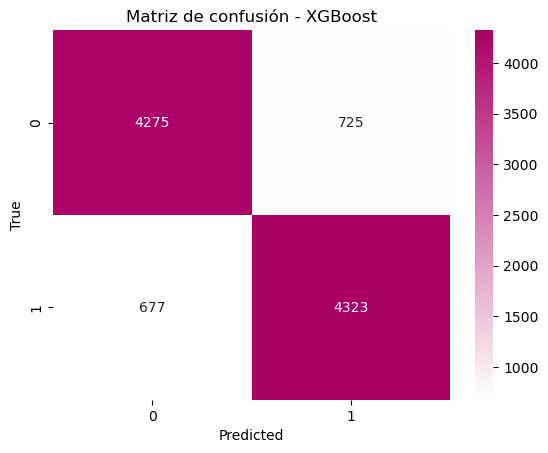

In [13]:
# Obtener la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Reporte y Matriz de Confusion
print(classification_report(y_test, y_pred))

# Definir colores
color_start = "#fff"
color_end = "#aa0065"

# Definir el mapa de colores personalizado con un degradado suave
cmap_colors = [color_start, color_end]
cmap = LinearSegmentedColormap.from_list("Custom", cmap_colors)

# Graficar la matriz de confusión con el mapa de colores personalizado
sns.heatmap(cm, cmap=cmap, annot=True, fmt='d', cbar=True)
plt.title("Matriz de confusión - XGBoost")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
# Mapear las etiquetas a valores numéricos para usar AUC
y_test_bin = y_test.replace(['positivo', 'negativo'], [1, 0])

# Convertir a Series para poder usar replace
y_pred_bin = pd.Series(y_pred).replace(['positivo', 'negativo'], [1, 0]) 

# Alternativa con numpy
# y_pred_bin = np.where(y_pred == 'positivo', 1, 0)

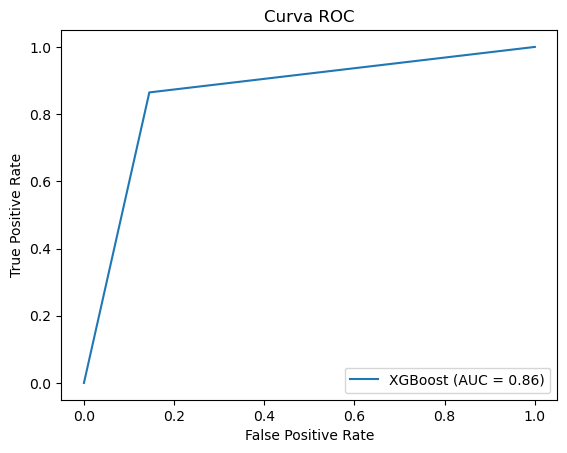

In [15]:
fpr, tpr, _ = roc_curve(y_test_bin, y_pred_bin) # FPR y TPR son acrónimos de "False Positive Rate" y "True Positive Rate"
roc_auc = roc_auc_score(y_test_bin, y_pred_bin)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBoost').plot()
plt.title("Curva ROC")
plt.legend(loc="lower right")  # agregar leyenda en la esquina inferior derecha
plt.show()

### Validación con K-Fold Cross-Validation

In [16]:
# scores = evaluate_model(model_opt, X_train, y_train, 4, 2, 'f1')
scores = model_opt.cv_results_['mean_test_score']

In [17]:
print('F1-score media: %.4f' % np.mean(scores))
scores

F1-score media: 0.8464


array([0.83405932, 0.84721132, 0.85151944, 0.85309128, 0.84614849])

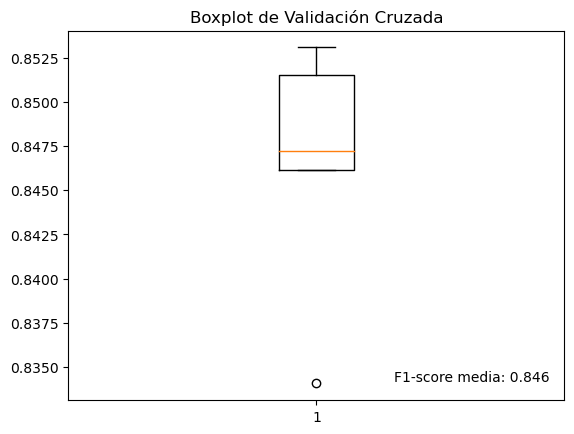

In [18]:
# Boxplot de los resultados
plt.boxplot(scores)
plt.title("Boxplot de Validación Cruzada")
plt.text(0.97, 0.05, 'F1-score media: {:.3f}'.format(np.mean(scores)),
         transform=plt.gca().transAxes, ha='right')
plt.show()


## Aplicación del modelo al dataset de test

Lectura del dataset de test original para mantener id:

In [19]:
df_test = pd.read_csv('../input/dataset/test_preprocesado.csv', sep=',', header=0)

In [20]:
y_pred_final = model_opt.predict(df_test[features])

In [21]:
# Mapear etiquetas a valores numéricos
# label_mapping = {'negativo': 0, 'positivo': 1}
# y_pred_final_numeric = np.array([label_mapping[label] for label in y_pred_final])

# Calcular las frecuencias
counts = np.bincount(y_pred_final)
count_1 = counts[1]  # Frecuencia de positivos
count_0 = counts[0]  # Frecuencia de negativos

print("Resultado de la predicción: ")
print("Positivos: ", count_1)
print("Negativos: ", count_0)

Resultado de la predicción: 
Positivos:  4886
Negativos:  3713


In [22]:
# Mapeo de prediccion numerica a etiqueta (positivo, negativo)
y_pred_final = np.where(y_pred_final == 1, 'positivo', 'negativo')

In [23]:
pd.concat([df_test['ID'],pd.DataFrame(data=y_pred_final, columns=['sentimiento'])], axis=1).to_csv('/kaggle/working/pred_xgb.csv', index=False)

## Exportación del modelo

In [24]:
dump(model_opt, open('/kaggle/working/modelo_xgb.pkl', 'wb'))